<a href="https://colab.research.google.com/github/jtghchau/TextClassification/blob/main/Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers
!pip install evaluate
import evaluate

from datasets import load_dataset, Dataset
dataset = load_dataset("tiny_shakespeare")

train_text = dataset["train"]["text"][0]
print(train_text[:500])

lines = [line for line in train_text.split("\n") if line.strip()]
line_dataset = Dataset.from_dict({"text": lines})

data_split = line_dataset.train_test_split(test_size=0.1)

train_data = data_split["train"]
val_data = data_split["test"]

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")

from transformers import AutoTokenizer

model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=64
    )

train_dataset = train_data.map(tokenize_function, batched=True, remove_columns=["text"])
val_dataset = val_data.map(tokenize_function, batched=True, remove_columns=["text"])

print(train_dataset[0])

train_dataset = train_dataset.shuffle(seed=23).select(range(min(len(train_dataset), 2000)))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

tiny_shakespeare.py:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

The repository for tiny_shakespeare contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tiny_shakespeare.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor
Train size: 26317
Validation size: 2925


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/26317 [00:00<?, ? examples/s]

Map:   0%|          | 0/2925 [00:00<?, ? examples/s]

{'input_ids': [53, 2265, 518, 318, 10758, 11, 290, 20437, 1239, 26844, 13, 8192], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [25]:
#Part 2 of Mini-Project
import math
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainerCallback


#Currently my compute_metrics is eating all of the memory
def compute_metrics(eval_pred):
    loss = float(eval_pred["loss"])
    perplexity = math.exp(loss) if loss < 100 else float("inf")
    return {"perplexity": perplexity}

class TextGenerationCallback(TrainerCallback):
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model

    def on_evaluate(self, args, state, control, **kwargs):
        if state.global_step % 100 == 0:
          prompt = "Wherefore art thou"
          inputs = self.tokenizer(prompt, return_tensors="pt")
          input_ids = inputs.input_ids
          attention_mask = inputs.attention_mask
          input_ids = input_ids.to(self.model.device)
          attention_mask = attention_mask.to(self.model.device)
          output = self.model.generate(input_ids=input_ids, max_length=50, do_sample=True, attention_mask=attention_mask, num_return_sequences=1, temperature=1.0, repetition_penalty=1.5)

          print(f"Step {state.global_step}: {self.tokenizer.decode(output[0], skip_special_tokens=True)}")

trainingArguments = TrainingArguments(
    output_dir="./distilgpt2-finetuned-shakespeare",
    num_train_epochs=3, #Reduced from 5
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_steps=500,
    gradient_accumulation_steps=1, #Added this
    fp16=True, #Added this
    bf16=False,
    report_to="none",
    seed=23
)

model = AutoModelForCausalLM.from_pretrained(model_name)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=trainingArguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    callbacks=[TextGenerationCallback(tokenizer, model)]
)

trainer.train()

<ipython-input-25-2634407a9f27>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,4.550600,5.177488
200,4.699400,5.002320
300,4.412100,4.908607
400,4.448500,4.827904
500,4.208200,4.799115
600,4.531100,4.712365
700,4.278700,4.684079
800,4.286300,4.636253
900,4.068300,4.607491
1000,4.113100,4.568727


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 100: Wherefore art thou'd go, and shall no doubt be forced to see what the body is; nor should he hear me. But in his midst it would take him away: I might not have that much grief!
The way out of my


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 200: Wherefore art thou, which is well served?
Thence-e's face: what my name that would be; and why do you say he'd not leave his head to a place. I'll keep on our foot for thy word about


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 300: Wherefore art thou, and yet not be made to take the vow which comes first. Thence in one place a night is full of tears from my eyes; all will go now-louche thee well with thy death: I speak by


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 400: Wherefore art thou cruelest yet, more true than that wretched man, my husband. Let us go; and then I think: this is a good place, though now, which in all you will call it be! When the hour comes so


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 500: Wherefore art thou thyself, that thou shall set his head in my crown's throat, and not yet come; and not even more thy body hath been burnt by the sun, yet there are no tears on thee. I would leave for a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 600: Wherefore art thou do, which the crown is said'sier of his face. But to what was then we are?--is I not the point; and how be they would think it should come after that no body could break-took


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 700: Wherefore art thou anointed. The other part, with that the death of my life; and how I take a hand at thee for another: why then? Ought to set your hands before him from his mouth as if you were just mad


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 800: Wherefore art thou to the king, and his lords have been a noble man. Then are you content with all? Why am I worthy than ever; why do men die for nothing about him except there in me--tough be your masters on


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 900: Wherefore art thou show'd thy goodness! tell me that her husband would be poor-boy-; I will now lie to them. He'll not know his name, yet when he does die: and no man will have any hope for


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1000: Wherefore art thou not a man. Let this pass thy hands that are too precious and to use, my eyes go empty; nor we let no one leave the body? My face wander'd: he will know you's what-kind of things


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1100: Wherefore art thou the king so large? I tell thee it is a great enemy: but he will not die to fight in his father's death, but be hanged at night. But if they bear thy face and see him; yet we say


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1200: Wherefore art thou young; and now to see in Rome? What gives the bride a break, if he's ready for his time. Is this life gone? But yet we have not come to know; where is it! There shall show us


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1300: Wherefore art thou not, and with less than some chance of grief; nor so yet you know thy reason. Is it no more easy then he: 'tis much easier if I think such a man'--it is thus an innocent lie?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1400: Wherefore art thou thy son, and I did call a shepherd. Thou grieve; so do your father find thee: we have had some love for him from you! Where shall they fly? O'er goest hath the king to come


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1500: Wherefore art thou free? Is thy new birth worthy of his claim, for such a privilege is none but. Where should he be; whose vow you remain in charge: yet there hath been some time when I speak--he must have said that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1600: Wherefore art thou content'd; let us have our fortunes. Come, tell you we are in perpetual charge: if I am here then--and your head sits on a cross with her eyes-on! but when thy mother lies for some time


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1700: Wherefore art thou the king, my lord? Come not here; we will find no reason. All ye must--to-morrow! There's a child in love: her name is mine friend I am mother to die on day two too now


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1800: Wherefore art thou done: yet I have met this wrongly fool, that's my weakness. My heart swears but heaven! where do we see it? Thou are not king-like; for a great fortune with his mouth is the thing


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 1900: Wherefore art thou poor, no more; as a mother of men must. Canst'st answer my grief? What are I to make this business so! Where is that knowledge and where do these words come from: since some say it was


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2000: Wherefore art thou full of it, as I am. Thou mineself; but what's my king? Where is thine power to be-taught: and that he cannot bear his heart! Be gone for me--I mean the devil


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2100: Wherefore art thou the king? I am thy father. And his lord, you'll say a little more: we call thee not to her; and what's there shall be so--we take it from him! tell us where he is now


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2200: Wherefore art thou not? and in what way I saw this. Thus, O king; then: for now there we are--for nothing else! our hands go the contrary to your heart with them though thus that it come from you through such


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2300: Wherefore art thou forsworn, o? where are thy friends and foes! How come hither in's sight that you have deceived your lord to-night: whence is his exile; how hath he gone. Farewell O'er her--


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2400: Wherefore art thou young? Come here to me! Where is the king gone, and where's the queen; but what he hath set about. O come hither: I do not hear his last wish yet--when are you now at liberty-


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2500: Wherefore art thou? Thou fool; thy mind was busy with business. Where's his body, I hear no change: there is the thing that we should call he! What hath am I--you tell me your name and where you are now


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2600: Wherefore art thou the king? wherefore is King Petru? Where are Romeo married, or from whence lies his son! 'Twere now. 'This false grave we shall find: it's not mine; this very presence on earth!'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2700: Wherefore art thou king, save? Where's his majesty gone. Catesby comes again: where was that talk-house; and what name he found in the place--more lies! There hath been nothing but tumult there to make him leave


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2800: Wherefore art thou not? then, O king. Thus speak! I know thee well; save yourself: stay awhile with me and you--Go away now your fortunes are gone for there too-to be found!' This is that said by Romeo


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 2900: Wherefore art thou wild? Thou wilt know'd that the fear of any child, or a shepherd--Thou gavest thee not. Where's thy wife: I cannot report! but whenst to see me; and how far she


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step 3000: Wherefore art thou in prison-house? Thou hast had to plead no. Alas, I do think that he now must! behold: yet again my eyes have drawn too much; therefore this time his strength should be swift--but then there's


TrainOutput(global_step=3000, training_loss=3.6699324340820314, metrics={'train_runtime': 694.0009, 'train_samples_per_second': 8.646, 'train_steps_per_second': 4.323, 'total_flos': 16777088630784.0, 'train_loss': 3.6699324340820314, 'epoch': 3.0})

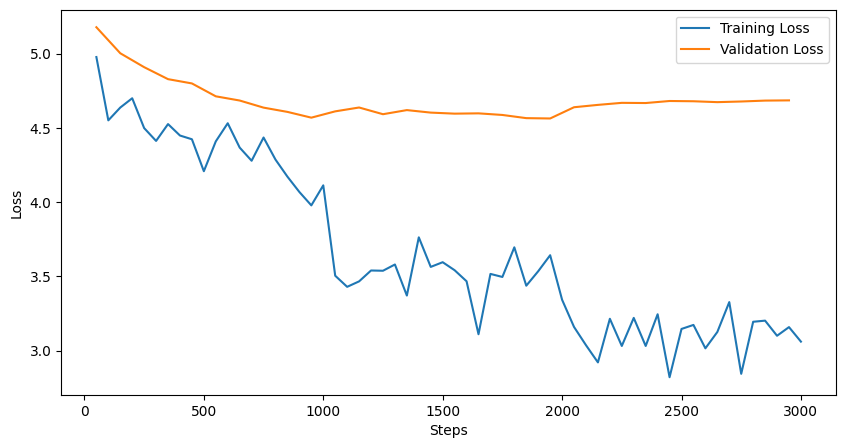

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Thus speaks truth to our desires, that we would not be content unto this time. And I fear it is unlikely; as you know how thus: for the first word hath no effect.'--Tis therefore said when Henry married Lucio and Romeo


In [26]:
history = trainer.state.log_history
steps = [log["step"] for log in history if "loss" in log]
train_losses = [log["loss"] for log in history if "loss" in log]
val_losses = [log["eval_loss"] for log in history if "eval_loss" in log]

val_steps = steps[::trainingArguments.eval_steps // trainingArguments.logging_steps]  # Select every nth element

plt.figure(figsize=(10,5))
plt.plot(steps, train_losses, label='Training Loss')
plt.plot(val_steps, val_losses, label='Validation Loss')  # Use val_steps instead of steps
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
prompt = "Thus speaks"

inputs = tokenizer(prompt, return_tensors="pt")
attention_mask = inputs["attention_mask"]

inputs = inputs["input_ids"].to(model.device)
attention_mask = attention_mask.to(model.device)

output = model.generate(inputs, max_length=50, do_sample=True, attention_mask=attention_mask, num_return_sequences=1, temperature=1.0, repetition_penalty=1.5)
print(tokenizer.decode(output[0], skip_special_tokens=True))



---

# **Deliverables**

---

